<a href="https://colab.research.google.com/github/MarciovsRocha/prototipo-tcc/blob/master/prototipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import importlib.util
import subprocess
import sys

def install_if_needed(package):
    if importlib.util.find_spec(package) is None:
        print(f"{package} is not installed. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

In [2]:
install_if_needed("sentence-transformers")

sentence-transformers is not installed. Installing...


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing

In [4]:
def load_datasets(folder, filename_text, filename_ts, start_date=None, end_date=None):
  # Load the CSV file into a DataFrame
  text_df = pd.read_csv(
      folder+filename_text,
      on_bad_lines="warn",
      parse_dates = ["date"],
      low_memory=False,
  )
  # Ignorar linhas com valores faltantes
  text_df.dropna(inplace=True)

  text_df.date = pd.to_datetime(text_df.date).dt.tz_localize(None)
  text_df.sort_values("date", inplace=True)
  text_df.stock = pd.Categorical(text_df.stock)

  ts_df = pd.read_csv(folder+filename_ts, usecols=["date", "close", "volume"])

  # Ignorar linhas com valores faltantes
  ts_df.dropna(inplace=True)

  ts_df.date = pd.to_datetime(ts_df.date).dt.tz_localize(None)
  ts_df.sort_values("date", inplace=True)

  if start_date:
      text_df = text_df[text_df.date >= start_date]
      ts_df = ts_df[ts_df.date >= start_date]
  if end_date:
      text_df = text_df[text_df.date < end_date]
      ts_df = ts_df[ts_df.date < end_date]

  return text_df, ts_df

def print_text_dataset_info(df):
  df.groupby(df.date.dt.year).size().plot(kind="bar")
  plt.title("Quantidade de notícias por Ano")
  plt.xlabel("N")
  plt.ylabel("Info")
  plt.show()

  news_count_per_day = df.groupby("day").size()
  plt.figure(figsize=(10, 6))
  plt.hist(news_count_per_day, bins=100, edgecolor='blue', align='left')
  plt.xlabel('Quantidade de notícias por dia')
  plt.ylabel("Numero de dias")
  plt.title('Frequência de dias com uma quantidade de notícias')
  plt.grid(axis='y')
  plt.show()

def preprocess_texts(df, target_stock="EBAY"):
  # Identificar todas a linhas duplicadas que não sejam target e removelas
  duplicates = df[df.duplicated(subset=["date", "title"], keep=False)]
  to_drop = duplicates[duplicates.stock != target_stock]
  df_dedup = df.drop(to_drop.index)

  # Remover dias com numero muito pequeno de noticias
  df_dedup["day"] = df_dedup["date"].dt.normalize()
  news_count_per_day = df_dedup.groupby("day").size()
  days_with_less_news = news_count_per_day[news_count_per_day < 25].index
  df_cleaned = df_dedup[~df_dedup["day"].isin(days_with_less_news)]

  return df_cleaned


def preprocess_ts(df):
  df_cleaned = df.copy()
  # Transformar dados para a mudança em porcentagem do dia anterior
  percentage_change_columns = [col for col in df_cleaned.columns if col not in ["date", "volume"]]
  for col in percentage_change_columns:
    df_cleaned[col] = df_cleaned[col].pct_change()

  df_cleaned.dropna(inplace=True)

  return df_cleaned

def print_stock_validation_info(df, stock, val_year=2020):

  val_df = df[df.date.dt.year == val_year]
  target_df = val_df[val_df.stock == stock]
  GTn_p = len(target_df) / len(val_df)
  GTd_p = target_df.day.nunique() / val_df.day.nunique()
  val_df_on_days_with_stock = val_df[val_df.day.isin(val_df[val_df.stock == stock].day)]
  target_df_on_days_with_stock = target_df[target_df.day.isin(target_df[target_df.stock == stock].day)]
  GTn_in_GTd_p = len(target_df_on_days_with_stock) / len(val_df_on_days_with_stock)
  max_GTn = target_df.groupby(target_df.day).count().max().stock

  print("Percentagem das noticias categorizadas com o stock")
  print(f"{GTn_p = }")
  print("Percentagem de dias com notícias categorizadas com o stock")
  print(f"{GTd_p = }")
  print("Percentagem das noticias categorizadas com o stock em dias com pelo menos uma notícia dela")
  print(f"{GTn_in_GTd_p = }")
  print("Dia com número maximo de noticias categorizadas com o stock")
  print(f"{max_GTn = }")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carregar datasets

In [6]:
DATASET_FOLDER = "./drive/MyDrive/PUCPR_TCC_BCC/Datasets/"
target_stock = "EBAY"
raw_text_df, raw_ts_df = load_datasets(folder=DATASET_FOLDER, filename_text="kaggle_analyst_ratings.csv", filename_ts=f"time_series/{target_stock}.csv", start_date="2019", end_date="2021")
text_df = preprocess_texts(raw_text_df)
ts_df = preprocess_ts(raw_ts_df)

In [7]:
text_df.head(5)

,title,date,stock,day
859120,Long-term Prospect Of The Memmory Market Remai...,2019-01-02 09:08:00,MU,2019-01-02
911456,NetEase Cloud Music Enters into Strategic Part...,2019-01-02 09:22:00,NTES,2019-01-02
54020,Albemarle Begins Earthworks At Kemerton Project,2019-01-02 11:35:00,ALB,2019-01-02
937464,Omega Healthcare Investors To Acquire MedEquit...,2019-01-02 11:46:00,OHI,2019-01-02
154899,"Baidu, Inc. Estimates 2018 Sales Exceeded RMB100M",2019-01-02 11:49:00,BIDU,2019-01-02


In [8]:
raw_ts_df

,date,close,volume
1256,2019-01-02,28.850000,11190300
1255,2019-01-03,28.320000,10803900
1254,2019-01-04,28.969999,14593700
1253,2019-01-07,29.469999,13419400
1252,2019-01-08,30.000000,8179700
...,...,...,...
756,2020-12-24,50.119999,2718500
755,2020-12-28,50.240002,6187400
754,2020-12-29,50.860001,4796700
753,2020-12-30,50.549999,8618900


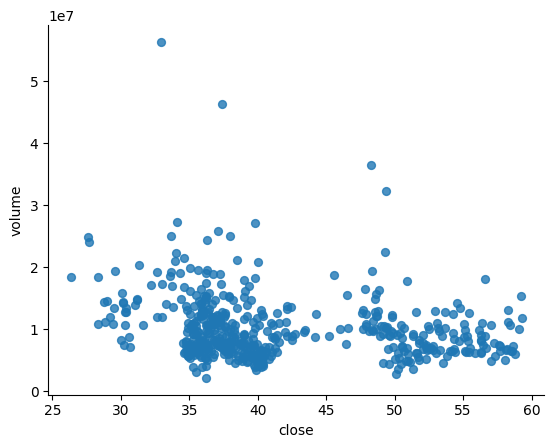

In [9]:
# @title close vs volume

from matplotlib import pyplot as plt
raw_ts_df.plot(kind='scatter', x='close', y='volume', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

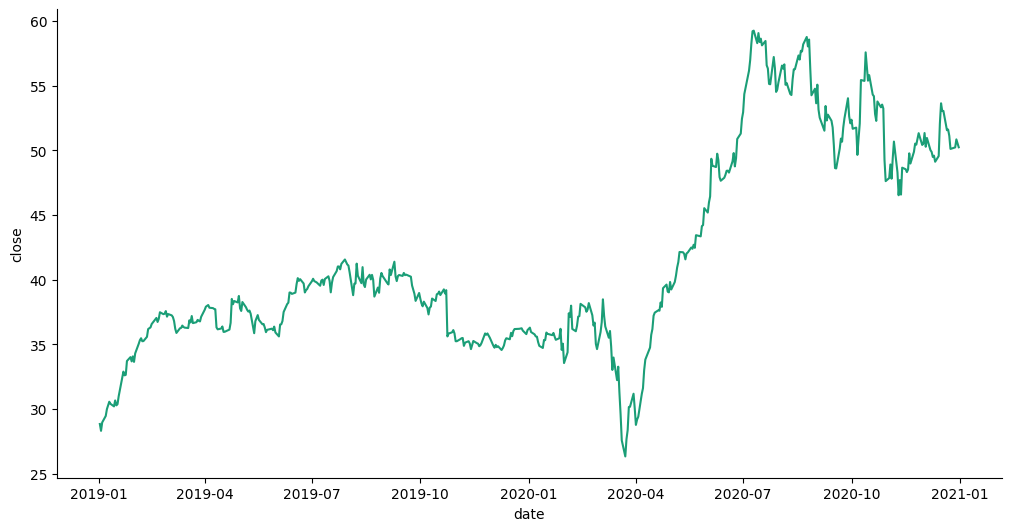

In [10]:
# @title date vs close

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = raw_ts_df.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('close')

In [11]:
ts_df

,date,close,volume
1255,2019-01-03,-0.018371,10803900
1254,2019-01-04,0.022952,14593700
1253,2019-01-07,0.017259,13419400
1252,2019-01-08,0.017984,8179700
1251,2019-01-09,0.009667,10607500
...,...,...,...
756,2020-12-24,-0.019754,2718500
755,2020-12-28,0.002394,6187400
754,2020-12-29,0.012341,4796700
753,2020-12-30,-0.006095,8618900


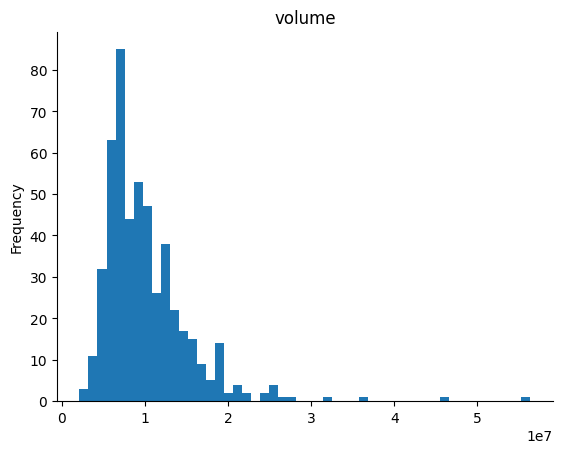

In [12]:
# @title volume

from matplotlib import pyplot as plt
ts_df['volume'].plot(kind='hist', bins=50, title='volume')
plt.gca().spines[['top', 'right',]].set_visible(False)

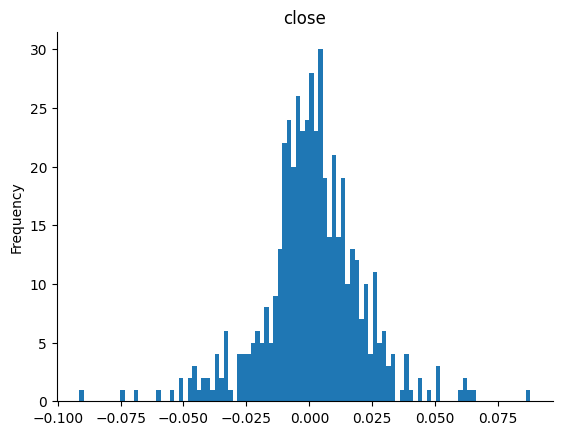

In [13]:
# @title close

from matplotlib import pyplot as plt
ts_df['close'].plot(kind='hist', bins=100, title='close')
plt.gca().spines[['top', 'right',]].set_visible(False)

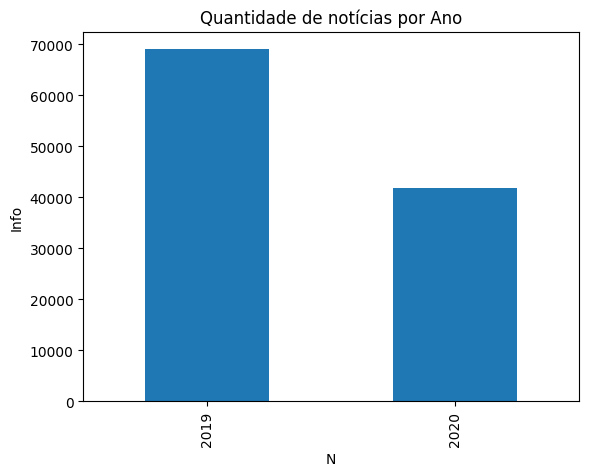

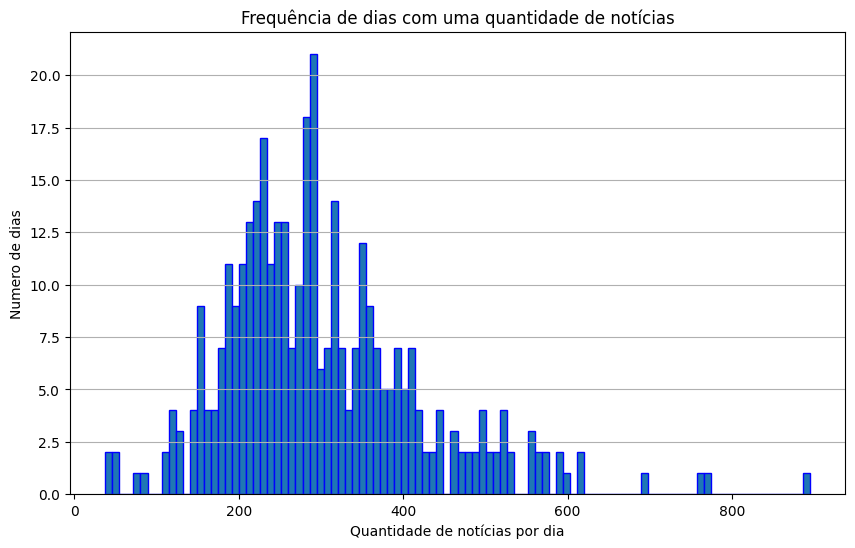

In [14]:
print_text_dataset_info(text_df)

In [15]:
print_stock_validation_info(text_df, stock=target_stock)

Percentagem das noticias categorizadas com o stock
GTn_p = 0.004370984307449781
Percentagem de dias com notícias categorizadas com o stock
GTd_p = 0.5714285714285714
Percentagem das noticias categorizadas com o stock em dias com pelo menos uma notícia dela
GTn_in_GTd_p = 0.007495392176940405
Dia com número maximo de noticias categorizadas com o stock
max_GTn = 19


# Carregar modelo de embeddings


In [16]:
from sentence_transformers import SentenceTransformer
encoder = SentenceTransformer("all-MiniLM-L6-v2")
encoder.encode("asd").shape[0]

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

384

# Implementar modelo MSIN


(DANG; SHAH; ZERFOS, 2019)

In [17]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils, utils, activations, losses, callbacks, backend

class ZeroLayer(layers.Layer):
    def __init__(self, output_shape, **kwargs):
        super().__init__(**kwargs)
        self.output_shape_ = output_shape

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return tf.zeros((batch_size,) + self.output_shape_)

    def compute_output_shape(self, input_shape):
        return (input_shape[0],) + tuple(self.output_shape_)

class InitialState(layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="zeros"
        )
        self.built = True

    def call(self, inputs):
        num_docs = tf.reduce_max(tf.math.count_nonzero(inputs, axis=1), axis=0)
        num_docs = tf.cast(num_docs, tf.float32)
        total = tf.reduce_sum(inputs, axis=1)
        avg = tf.divide(total, num_docs)

        return activations.tanh(tf.matmul(avg, self.w) + self.b)

# Define the multi-step interrelation mechanism
class MSINCell(layers.Layer):
    def __init__(self, n, m, ds, dh, D, dropout=0.0, recurrent_dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.n = n
        self.m = m
        self.ds = ds
        self.dh = dh

        kernel_init = "random_normal"
        bias_init = "zeros"

        # Text attention weights
        self.W_a = self.add_weight(shape=(ds, ds), initializer=kernel_init)
        self.U_a = self.add_weight(shape=(dh, ds), initializer=kernel_init)
        self.b_a = self.add_weight(shape=(ds,), initializer=bias_init)
        self.v_a = self.add_weight(shape=(ds,), initializer=kernel_init)


        # LSTM [Input, Forget, Candidate, Output] Gate Weights
        self.kernel_x = self.add_weight(shape=(D, ds * 4), initializer=kernel_init)
        self.kernel_h = self.add_weight(shape=(dh, ds * 4), initializer=kernel_init)
        self.kernel_v = self.add_weight(shape=(dh, ds * 4), initializer=kernel_init)
        self.b_i = self.add_weight(shape=(ds,), initializer=bias_init)
        self.b_f = self.add_weight(shape=(ds,), initializer="ones")
        self.b_c = self.add_weight(shape=(ds,), initializer=bias_init)
        self.b_o = self.add_weight(shape=(ds,), initializer=bias_init)


        self.built = True

    def call(self, inputs, states, constants, training=False):
        # print(f"from cell: {inputs.shape = }")
        # print(f"from cell: {states = }")

        h_tm1 = states[0]
        c_tm1 = states[1]
        v_tm1 = states[2]
        p_tm1 = states[3]
        s, = constants

        p = self.calc_p(s, h_tm1)
        v = self.calc_v(s, p, v_tm1)

        kx_i, kx_f, kx_c, kx_o = tf.split(self.kernel_x, 4, axis=1)
        x_i = tf.matmul(inputs, kx_i)
        x_f = tf.matmul(inputs, kx_f)
        x_c = tf.matmul(inputs, kx_c)
        x_o = tf.matmul(inputs, kx_o)

        kh_i, kh_f, kh_c, kh_o = tf.split(self.kernel_h, 4, axis=1)
        h_i = tf.matmul(h_tm1, kh_i)
        h_f = tf.matmul(h_tm1, kh_f)
        h_c = tf.matmul(h_tm1, kh_c)
        h_o = tf.matmul(h_tm1, kh_o)

        kv_i, kv_f, kv_c, kv_o = tf.split(self.kernel_v, 4, axis=1)
        v_i = tf.matmul(v, kv_i)
        v_f = tf.matmul(v, kv_f)
        v_c = tf.matmul(v, kv_c)
        v_o = tf.matmul(v, kv_o)

        i = activations.sigmoid(x_i + h_i + v_i + self.b_i)
        f = activations.sigmoid(x_f + h_f + v_f + self.b_f)
        cand = activations.tanh(x_c + h_c + v_c + self.b_c)
        o = activations.sigmoid(x_o + h_o + v_o + self.b_o)

        c = f * c_tm1 + i * cand
        h = o * activations.tanh(c)

        return h, [h, c, v, p]

    def calc_p(self, s, h_tm1):
        # einsum (None, n, dh) (dh, ds) = (None, n, ds)
        u_part = tf.einsum("bij,jk->bik", s, self.U_a)
        # (None, ds) * (ds, ds) -> expand1 = (None, 1, ds)
        w_part = tf.expand_dims(tf.matmul(h_tm1, self.W_a), axis=1)
        # (None, n, ds) + (None, 1, ds) + (ds,) = (None, n, ds)
        a = activations.tanh(w_part + u_part + self.b_a)
        # sum-1 ((None, n, ds) * (ds,)) = (None, n)
        return activations.softmax(tf.reduce_sum(a * self.v_a, axis=-1))

    def calc_v(self, s, p, v_tm1):
        p = tf.expand_dims(p, axis=-1)
        # (None, n, 1) * (None, n, dh) = (None, n, dh)
        # sum axis1 (None, n, dh) = (None, dh)
        sum_avg = tf.reduce_sum(p * s, axis=1)
        return (sum_avg + v_tm1) / 2

    @property
    def output_size(self):
        return self.ds

    @property
    def state_size(self):
        return [self.ds, self.ds, self.ds, self.n]


In [18]:
# parameters
m_time_steps = 5
D_time_series_dimension = 2
n_news_batch = 35
ds_num_neural_units = 64
dh_encoding_dimension = 64
dhp_embedding_dimension = len(encoder.encode("sample"))

def make_model(m, n, D, ds, dh, dhp):

    # Time Series Input
    time_series_input = layers.Input(shape=(m, D), dtype="float32", name="ts")

    # Define the text embeddings input

    text_embedding_input = layers.Input(shape=(n, dhp), name="text_embeddings")
    condensed_embeds = layers.Dense(dh, name="representative_vectors")(text_embedding_input)

    h0 = InitialState(units=ds, name="initial_state_h")(condensed_embeds)
    c0 = InitialState(units=ds, name="initial_state_c")(condensed_embeds)
    # v0 = backend.zeros((ds,))
    # p0 = backend.zeros((n, ))
    v0 = ZeroLayer((ds,), name="initial_state_v")(condensed_embeds)
    p0 = ZeroLayer((n, ), name="initial_state_p")(condensed_embeds)
    # v0 = layers.Input(tensor=tf.constant(0.0, shape=(ds,), dtype=tf.float32), name="initial_state_v")
    # p0 = layers.Input(tensor=tf.constant(0.0, shape=(n,), dtype=tf.float32), name="initial_state_p")
    # initial state has to be same length as whats used internally
    # h0, c0, s, v, p
    msin_initial_state = [h0, c0, v0, p0]

    msin_cell = MSINCell(n=n, m=m, ds=ds, dh=dh, D=D)
    msin = layers.RNN(msin_cell, name="MSIN", return_sequences=True, return_state=True)(time_series_input, initial_state=msin_initial_state, constants=[condensed_embeds])

    hidden_layer_output = layers.Lambda(lambda x: x[0], name="hidden_layer")(msin)
    vector_weights = layers.Lambda(lambda x: x[-1], name="weights")(msin)

    concatenation = layers.concatenate([hidden_layer_output, condensed_embeds], axis=1, name="concatenate")
    output_layer = layers.Flatten()(concatenation)
    output_layer = layers.Dropout(0.2)(output_layer)
    output_layer = layers.Dense(ds, name="output_layer")(output_layer)
    ts_pred = layers.Dense(1, name="ts_pred")(output_layer)

    model = models.Model(
        name="MSIN",
        inputs={"ts": time_series_input, "text_embeddings": text_embedding_input},
        outputs={"ts_pred": ts_pred, "weights": vector_weights},
    )

    return model

model = make_model(
    m=m_time_steps,
    n=n_news_batch,
    D=D_time_series_dimension,
    ds=ds_num_neural_units,
    dh=dh_encoding_dimension,
    dhp=dhp_embedding_dimension,
)

model.summary()

Model: "MSIN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_embeddings (InputLaye  [(None, 35, 384)]            0         []                            
 r)                                                                                               
                                                                                                  
 representative_vectors (De  (None, 35, 64)               24640     ['text_embeddings[0][0]']     
 nse)                                                                                             
                                                                                                  
 ts (InputLayer)             [(None, 5, 2)]               0         []                            
                                                                                               

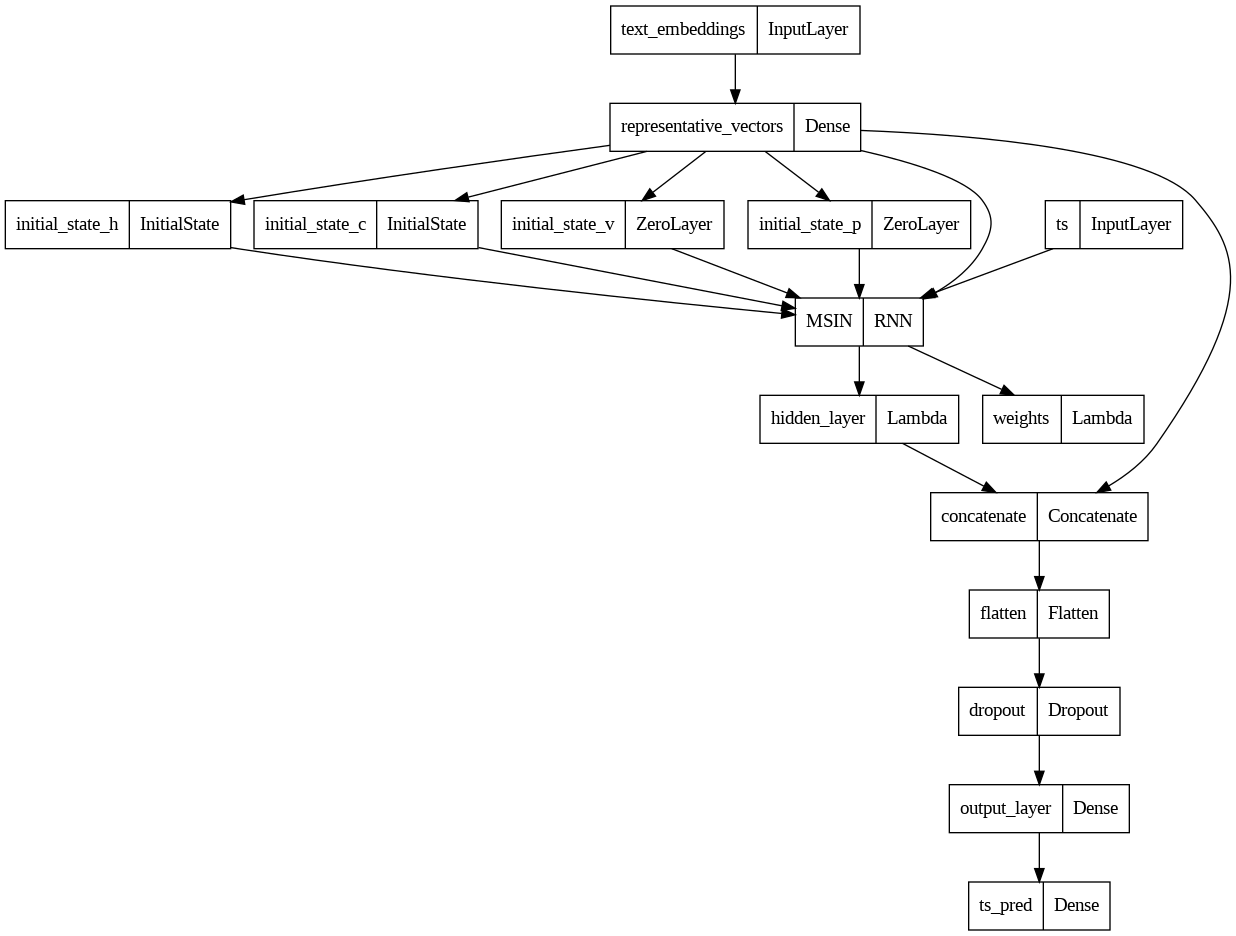

In [19]:
utils.plot_model(model)

# Lidar com desbalanceamento na base

TODO

# Processar dados para o formato de entrada do modelo

In [20]:
def process_time_series(ts_df, dates, timesteps=m_time_steps):
    ts_df = ts_df[ts_df.date.isin(dates)]
    date_column = ts_df.date
    ts_df = ts_df.copy().drop("date", axis=1)
    X = []
    y = []
    ts_dates = []
    for i in range(len(ts_df) - timesteps):
      if date_column.iloc[i+timesteps] not in dates:
        continue
      X.append(ts_df.iloc[i:i+timesteps].values)
      y.append(ts_df.iloc[i+timesteps]["close"])
      ts_dates.append(date_column.iloc[i+timesteps])

    X_df = np.array(X)
    y_df = np.array(y)

    return X_df, y_df, ts_dates

def collect_news_headlines(text_df, dates, max_headlines, target):
    news_per_day = []
    targets = []
    for date in dates:
      headlines = text_df[text_df.day == date]["title"].values[:max_headlines]
      is_target = text_df[text_df.day == date]["stock"].values[:max_headlines] == target
      headlines = list(headlines) + [''] * (max_headlines - len(headlines))
      news_per_day.append(headlines)
      targets.append(is_target)

    headlines_df = np.array(news_per_day)
    text_y = np.array(targets)

    return headlines_df, text_y

dates_with_news = text_df.day.unique()
ts_X, ts_y, dates_for_news = process_time_series(ts_df, dates_with_news)

text_X, text_y = collect_news_headlines(text_df, dates_for_news, n_news_batch, target_stock)

In [21]:
ts_X.shape, ts_y.shape, text_X.shape, text_y.shape

((358, 5, 2), (358,), (358, 35), (358, 35))

In [22]:
text_X[:3]

array([['U.S. Judge Issues Proposed Order To Restrict PG&E Energy Transmission During High Winds In 2019 Wildfire Season ; Judge Says Likely Means Having To Interrupt Service During High-wind Event',
        'Equinix to Extend Interconnection and Data Center Services to Hamburg',
        'Cancer Genetic Prices 13.33M Share Offering @$0.225/Share',
        'Craig Harris Assumes COO Role at Enable Midstream Partners',
        'Server DRAM Demand Slowing Since Q3 2018 but Outlook Optimistic',
        'EU Court Adviser Says Google Can Limit Right to be Forgotten to EU',
        'Novartis Response To Nice Appraisal Consultation Document For Aimovig For The Prevention Of Migraine',
        'Emmis Communications Q3 EPS $0.05 Up From $(0.02) YoY, Sales $30.323M Down From $35.345M YoY',
        'ChipMOS Q4 Sales $162.4M, Down 0.7% Quarter Over Quarter, Up 12.8% Year Over Year',
        'Lilis Energy Reports Achieved 2018 Year-End Exit Rate Target Of 8K Net Barrels Of Oil Equivalent Per Day',
  

In [23]:
ts_X[:3]

array([[[-1.83709074e-02,  1.08039000e+07],
        [ 2.29519642e-02,  1.45937000e+07],
        [ 1.72592341e-02,  1.34194000e+07],
        [ 1.79844146e-02,  8.17970000e+06],
        [ 9.66669718e-03,  1.06075000e+07]],

       [[ 2.29519642e-02,  1.45937000e+07],
        [ 1.72592341e-02,  1.34194000e+07],
        [ 1.79844146e-02,  8.17970000e+06],
        [ 9.66669718e-03,  1.06075000e+07],
        [ 9.24393433e-03,  8.74140000e+06]],

       [[ 1.72592341e-02,  1.34194000e+07],
        [ 1.79844146e-02,  8.17970000e+06],
        [ 9.66669718e-03,  1.06075000e+07],
        [ 9.24393433e-03,  8.74140000e+06],
        [-5.23388449e-03,  1.33909000e+07]]])

In [24]:
ts_y[:3]

array([ 0.00924393, -0.00523388, -0.00657681])

In [25]:
text_y[:3,:]

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False]])

# Separar dados entre teste e treino

In [26]:
def train_test_series_split(*datasets, train_ratio = 0.8):
  train_sets = []
  test_sets = []

  for s in datasets:
    split_index = int(len(s) * train_ratio)
    if isinstance(s, pd.DataFrame):
      train_sets.append(s.iloc[:split_index])
      test_sets.append(s.iloc[split_index:])
    else:
      train_sets.append(s[:split_index])
      test_sets.append(s[split_index:])

  return train_sets, test_sets

(ts_X_train_, text_X_train_, ts_y_train_, text_y_train_), (ts_X_test_, text_X_test_, ts_y_test_, text_y_test_) = train_test_series_split(ts_X, text_X, ts_y, text_y)

In [27]:
ts_X_train_.shape, text_X_train_.shape, ts_y_train_.shape, text_y_train_.shape, ts_X_test_.shape, text_X_test_.shape, ts_y_test_.shape, text_y_test_.shape

((286, 5, 2),
 (286, 35),
 (286,),
 (286, 35),
 (72, 5, 2),
 (72, 35),
 (72,),
 (72, 35))

# Aplicar normalização baseado nos dados de treino

In [28]:
class TsScaler:
  def __init__(self, ts, y_feature=0):
    self.scalers = []
    self.y_feature = y_feature
    for dimention in range(ts.shape[-1]):
      scaler = preprocessing.RobustScaler()
      scaler.fit(ts[:,0,dimention].reshape(-1, 1))

      self.scalers.append(scaler)


  def transform_all(self, ts):
    scaled_ts = np.empty_like(ts)
    for step in range(ts.shape[1]):
      for dimention, scaler in enumerate(self.scalers):
        scaled_ts[:,step,dimention] = scaler.transform(ts[:,step,dimention].reshape(-1, 1))[:,0]

    return scaled_ts

  def transform_close(self, ts):
    scaled_ts = self.scalers[self.y_feature].transform(ts.reshape(-1, 1))[:,0]
    return scaled_ts


scaler = TsScaler(ts_X_train_)
ts_X_train = scaler.transform_all(ts_X_train_)
ts_X_test = scaler.transform_all(ts_X_test_)
ts_y_train = scaler.transform_close(ts_y_train_)
ts_y_test = scaler.transform_close(ts_y_test_)

In [29]:
ts_X_train[:3]

array([[[-1.21303334,  0.63493153],
        [ 1.37333857,  1.46096045],
        [ 1.01703426,  1.20500875],
        [ 1.06242284,  0.06295806],
        [ 0.54182227,  0.59212398]],

       [[ 1.37333857,  1.46096045],
        [ 1.01703426,  1.20500875],
        [ 1.06242284,  0.06295806],
        [ 0.54182227,  0.59212398],
        [ 0.51536181,  0.1853868 ]],

       [[ 1.01703426,  1.20500875],
        [ 1.06242284,  0.06295806],
        [ 0.54182227,  0.59212398],
        [ 0.51536181,  0.1853868 ],
        [-0.39079554,  1.19879685]]])

In [30]:
ts_y_train[:3]

array([ 0.51536181, -0.39079554, -0.47484833])

# Criar embeds

In [31]:
def create_embeds(arr):
  embeds = []
  for column in range(arr.shape[1]):
    embed = encoder.encode(arr[:,column])
    embeds.append(embed)

  return np.stack(embeds, axis=1)


text_X_train = create_embeds(text_X_train_)
text_X_test = create_embeds(text_X_test_)
text_X_train.shape, text_X_test.shape

((286, 35, 384), (72, 35, 384))

# Treinar modelo

In [32]:
model = make_model(
    m=m_time_steps,
    n=n_news_batch,
    D=D_time_series_dimension,
    ds=ds_num_neural_units,
    dh=dh_encoding_dimension,
    dhp=dhp_embedding_dimension,
)

model.compile(optimizer="adam", loss={"ts_pred": "mse"})

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(x={"ts": ts_X_train, "text_embeddings": text_X_train}, y={"ts_pred": ts_y_train}, epochs=100, batch_size=8, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
33/33 [==============================] - 8s 56ms/step - loss: 0.8557 - ts_pred_loss: 0.8557 - val_loss: 2.9285 - val_ts_pred_loss: 2.9285
Epoch 2/100
33/33 [==============================] - 1s 23ms/step - loss: 0.3165 - ts_pred_loss: 0.3165 - val_loss: 2.9036 - val_ts_pred_loss: 2.9036
Epoch 3/100
33/33 [==============================] - 1s 16ms/step - loss: 0.1132 - ts_pred_loss: 0.1132 - val_loss: 2.7914 - val_ts_pred_loss: 2.7914
Epoch 4/100
33/33 [==============================] - 1s 17ms/step - loss: 0.0825 - ts_pred_loss: 0.0825 - val_loss: 2.8435 - val_ts_pred_loss: 2.8435
Epoch 5/100
33/33 [==============================] - 1s 16ms/step - loss: 0.1320 - ts_pred_loss: 0.1320 - val_loss: 2.7643 - val_ts_pred_loss: 2.7643
Epoch 6/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0896 - ts_pred_loss: 0.0896 - val_loss: 2.7928 - val_ts_pred_loss: 2.7928
Epoch 7/100
33/33 [==============================] - 1s 17ms/step - loss: 0.0706 - ts_pred_loss: 0.0

In [33]:
model.export("./drive/MyDrive/PUCPR_TCC_BCC/modelo_treinado_20240506")

Saved artifact at './drive/MyDrive/PUCPR_TCC_BCC/modelo_treinado_20240506'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 35, 384), dtype=tf.float32, name='text_embeddings'), TensorSpec(shape=(None, 5, 2), dtype=tf.float32, name='ts')]
Output Type:
  Dict[['ts_pred', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)], ['weights', TensorSpec(shape=(None, 35), dtype=tf.float32, name=None)]]
Captures:
  134677692014912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134677640524224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134677638934448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134677638932688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134677640518064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134677640521408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134677638892352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134677638900272: TensorSpec(s